## Uniform spatial surface. 48 x 48 (2,304 grids)|| 24 x 24 (576 grids) and || 16 x 16 (256 grids)

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls  
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
# Gaussian family initialization
family = Gaussian()
np.set_printoptions(precision=3, suppress=True)

#### DGP

- Create census tracts (polygon) and points with the same grid extents i.e 0-1200

In [2]:
# Function to create tract polygons over the area
def create_tracts(xmin, xmax, ymin, ymax, x_step, y_step):
    polys = []
    ids = []
    id_counter = 0
    for x0 in np.arange(xmin, xmax, x_step):
        for y0 in np.arange(ymin, ymax, y_step):
            x1 = x0 + x_step
            y1 = y0 + y_step
            poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
            polys.append(poly)
            ids.append(id_counter)
            id_counter += 1
    gdf = gpd.GeoDataFrame({'tract_id': ids, 'geometry': polys})
    return gdf

# Define grid parameters and create tracts
xmin, xmax = 0, 1200
ymin, ymax = 0, 1200

- Adjust the step size of the grid to increase or decrease the size of the tracts, so it has more or less points in it.

- The polygon target supports are S2 (target supports). I also simulate S1 points and corresponding locations, with a mean of 50 and standard deviation of 30. 

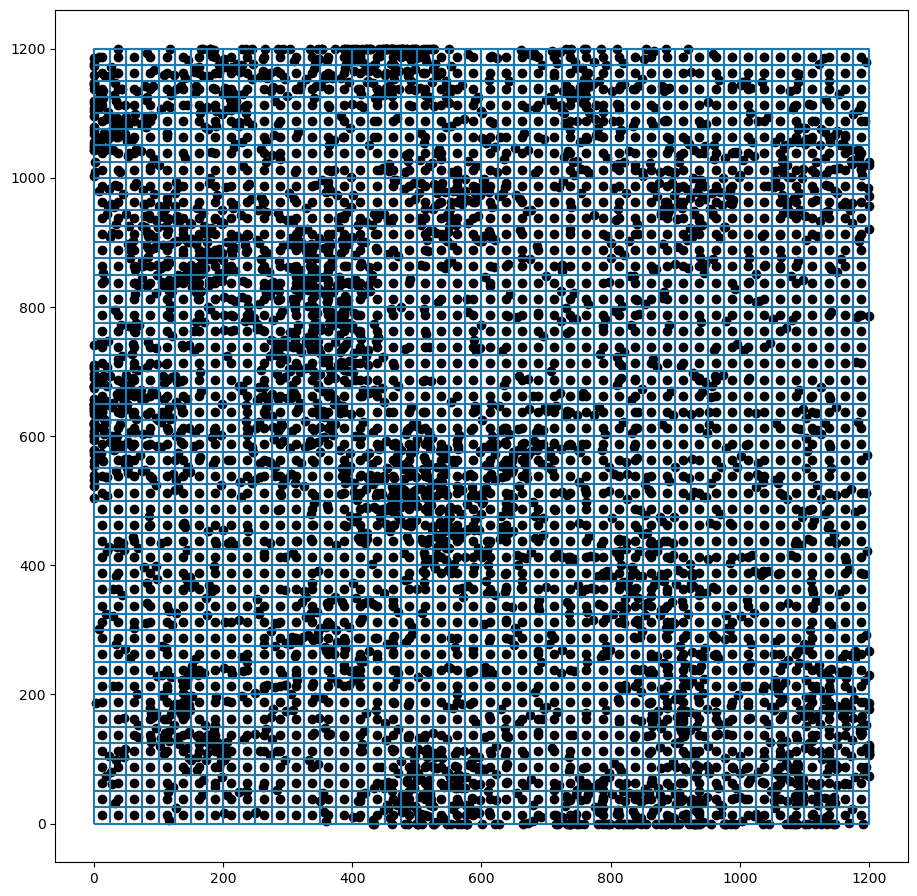

In [3]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 25, 25 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)


def simulate_clustered_S1(num_points, background_points, num_clusters, grid_gdf, cluster_std=50, random_state=None):
    """
    Simulates clustered S1 points, ensuring that each grid cell in S2 has at least one point.

    Parameters:
    - num_points: total number of points to generate in clusters
    - background_points: additional random background points
    - num_clusters: number of spatial clusters to create
    - grid_gdf: GeoDataFrame of grid cells (S2)
    - cluster_std: standard deviation of clusters (controls spread of points)
    - random_state: seed for reproducibility

    Returns:
    - S1: array of S1 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    if random_state is not None:
        np.random.seed(random_state)

    x_range = (grid_gdf.total_bounds[0], grid_gdf.total_bounds[2])
    y_range = (grid_gdf.total_bounds[1], grid_gdf.total_bounds[3])

    # Step 1: Ensure Each Grid Cell Gets At Least One Point
    guaranteed_points = []
    for _, row in grid_gdf.iterrows():
        centroid = row.geometry.centroid
        guaranteed_points.append([centroid.x, centroid.y])

    # Step 2: Generate Clustered Points
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    clustered_locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)

    # Clip points to stay within the study area
    clustered_locations[:, 0] = np.clip(clustered_locations[:, 0], x_range[0], x_range[1])
    clustered_locations[:, 1] = np.clip(clustered_locations[:, 1], y_range[0], y_range[1])

    # Step 3: Generate Additional Background Points
    background_locations = np.random.uniform(low=[x_range[0], y_range[0]], 
                                             high=[x_range[1], y_range[1]], 
                                             size=(background_points, 2))

    # Step 4: Combine All Points
    all_locations = np.vstack((guaranteed_points, clustered_locations, background_locations))

    # Step 5: Generate S1 Values (Normally Distributed)
    S1 = np.random.normal(50, 30, len(all_locations))

    return S1, np.array(all_locations)

# Define Grid Parameters for S2 (Areal Units)
xmin, xmax = 0, 1200
ymin, ymax = 0, 1200
x_step, y_step = 25, 25  # Creates a 48x48 grid (2304 tracts)
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Run Simulation with Ensured Coverage
S1, loc1 = simulate_clustered_S1(num_points=2000, background_points=1200, num_clusters=30, grid_gdf=tracts_gdf,
                                 cluster_std=50, random_state=12)

S2 = tracts_gdf48
loc2 = np.array([[point.x, point.y] for point in S2.geometry.centroid])

# plt.figure(figsize=(9,5))
tracts_gdf48.boundary.plot(figsize=(11,12))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc1[:,0], loc1[:,1], color='k');

#### Plot tracts and points

In [4]:
len(tracts_gdf48), len(S1)

(2304, 5504)

<br />

Rather than aggregating the points in each tract, the broad idea is to smooth the points around the centroid of each tracts and calibrate local regression with the smoothed values.

In [5]:
len(tracts_gdf48), len(S1)

(2304, 5504)

#### Create different beta surfaces and base DGP

 --> S1 denotes points<br />
 --> S2 denotes census tracts <br />
 --> loc1 denotes centroids of the S2 points <br />
 --> loc2 denotes the locations of the census tracts<br />

In [6]:
def create_beta_surface(locations, heterogeneity='low'):
    """
    Create beta surface with low or high spatial heterogeneity. defaults to low if none is specified.  
    """
    x, y = locations[:, 0], locations[:, 1]
    
    if heterogeneity == 'low':
        B = x / 600 + y / 600
    elif heterogeneity == 'high':
        B = np.sin(x/120) * np.cos(y/120) + (x-600)**2/1200 + (y-600)**2/1200

    Bmin, Bmax = np.min(B), np.max(B)
    B_norm = (B - Bmin) / (Bmax - Bmin) 
    B_scaled = 1 + B_norm*4
    return B_scaled
    
def uniform(locations):
    """
    Create constant surface with uniform/constant heterogeneity. 
    """
    surface = np.full(len(locations), 5)
    
    return surface


# B = create_beta_surface(loc2, heterogeneity='low')
B = uniform(loc2)
# Generate y values

# nbrs_S2 = NearestNeighbors(n_neighbors=np.random.randint(10, len(S2))).fit(loc1)
nbrs_S2 = NearestNeighbors(n_neighbors=50).fit(loc1)

smoothed_S1_to_S2 = np.zeros(len(S2))

for i in range(len(S2)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc2[i]])
    smoothed_S1_to_S2[i] = np.mean(S1[indices_S1_to_S2[0]].flatten())

y_orig = B * smoothed_S1_to_S2 

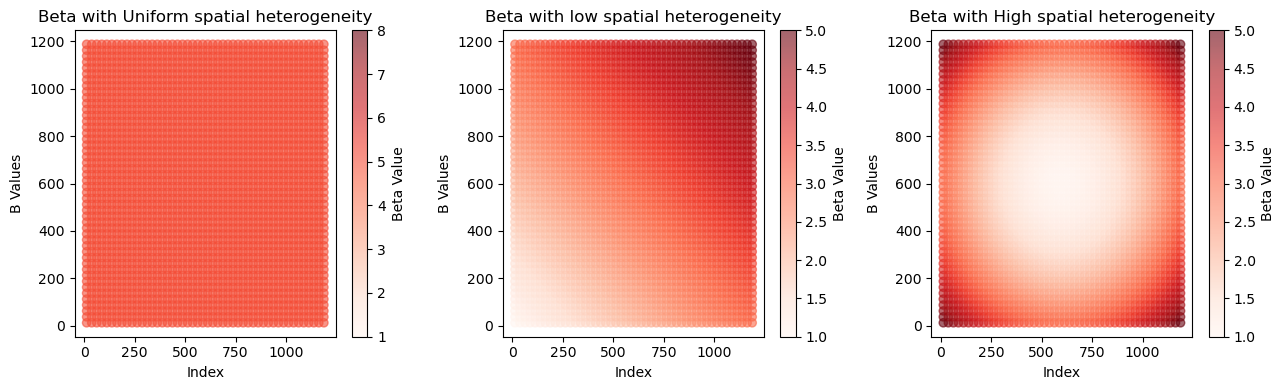

In [7]:
# Initialize beta

Beta_H = create_beta_surface(loc2, heterogeneity='high')
Beta_L = create_beta_surface(loc2, heterogeneity='low')
Beta_U = uniform(loc2)

plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.scatter(loc2[:,0], loc2[:, 1], c=Beta_U, cmap='Reds', vmin=1, vmax=8, alpha=0.6)
plt.xlabel('Index')
plt.ylabel('B Values')
plt.colorbar(label='Beta Value')
plt.title('Beta with Uniform spatial heterogeneity')
# plt.axis('off')

plt.subplot(1, 3, 2)
plt.scatter(loc2[:,0], loc2[:, 1], c=Beta_L, cmap='Reds', vmin=1, vmax=5, alpha=0.6)
plt.xlabel('Index')
plt.ylabel('B Values')
plt.colorbar(label='Beta Value')
plt.title('Beta with low spatial heterogeneity')
# plt.axis('off')

plt.subplot(1, 3, 3)
plt.scatter(loc2[:,0], loc2[:, 1], c=Beta_H, cmap='Reds', vmin=1, vmax=5, alpha=0.6)
plt.xlabel('Index')
plt.ylabel('B Values')
plt.colorbar(label='Beta Value')
plt.title('Beta with High spatial heterogeneity')
# plt.axis('off')


plt.tight_layout()
plt.show()


#### Helper function

In [8]:
def calculate_aicc_rss(n, RSS, tr_S):
    """GWR-style AICc calculation using RSS and trace of the hat matrix (tr_S)."""
    sigma2 = RSS / (n - tr_S)  # Correct variance calculation
    term1 = n * np.log(sigma2)
    term2 = n * np.log(2 * np.pi)
    term3 = n * ((n + tr_S) / (n - 2 - tr_S))
    
    aicc = term1 + term2 + term3
    return aicc

    
def calculate_aicc(n, log_likelihood, tr_S):
    """GWR-style AICc calculation using log-likelihood and trace of the hat matrix (tr_S)."""
    aic = -2 * log_likelihood + 2 * (tr_S + 1)
    aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 1)
    return aicc


def log_likelihood_gaussian(residuals, n, tr_S):
    """Calculate log-likelihood for Gaussian model with trace of hat matrix."""
    sigma2 = np.sum(residuals**2) / (n - tr_S)  
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    return log_likelihood
    
def plot_true_and_recovered(true, recovered, coord, name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', vmin=3.5, vmax=5.5, alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('True B Values ')
    plt.colorbar(label='Beta Value')
    plt.title(f'True B Values for {name}')
    
    plt.subplot(1, 2, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=recovered, cmap='Reds', vmin=3.5, vmax=5.5, alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('recovered B Values')
    plt.colorbar(label='Beta Value')
    plt.title(f'recovered B Values for {name}')
    
    plt.tight_layout()
    plt.show()
    

<br />

#### perform cos local regression

In [9]:
def perform_local_regression(n_neighbor_est, loc1, loc2, S1, S2, y):
    """
    Function that implements change of support into a GWR-like local model.
    
      - S1: point-level source support (X values) as a NumPy array
      - S2: areal unit target support (Y values) as a GeoDataFrame
      - loc1: array of point locations for S1
      - loc2: array of centroids for S2 (areal units)
    """
    N = len(S2)  # Number of areal units (S2)
    recovered_betas = np.zeros(N)
    residuals = np.zeros(N)
    y_pred = np.zeros(N)  # Store predicted y values
    S = np.zeros((N, N))
    family = Gaussian() 

    # Ensure S1 is a NumPy array
    if isinstance(S1, pd.DataFrame) or isinstance(S1, gpd.GeoDataFrame):
        S1 = S1.to_numpy().flatten()  # Convert to a 1D array

    # Initialize NearestNeighbors for smoothing S1 to S2
    nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)  # Neighbors from S1 (points)
    smoothed_S1_to_S2 = np.zeros(N)

    # Step 1: Smoothing X values (S1) to areal units (S2)
    for i in range(N):
        # Find nearest S1 points for each S2 centroid
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S1.kneighbors([loc2[i]])  
        bw_S1 = distances_S1_to_S2[0][-1]

        # Apply Gaussian kernel weighting
        distances_X = distances_S1_to_S2[0]
        weights_X = np.exp(-0.5 * (distances_X / bw_S1) ** 2)
        local_X = S1[indices_S1_to_S2[0]]  # Use S1 as the independent variable
        smoothed_S1_to_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)

    # Step 2: Local Regression using smoothed X data
    nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)  # Neighbors in S2 (areal units)
    
    for i in range(N):
        # Find neighbors in S2 for local regression
        distances_S2_to_S2, indices_S2_to_S2 = nbrs_S2.kneighbors([loc2[i]])
        bw_S2 = distances_S2_to_S2[0][-1]

        # Get y values of neighboring areal units
        y_neighbors = y[indices_S2_to_S2[0]].reshape(-1, 1)
        X_neighbors = smoothed_S1_to_S2[indices_S2_to_S2[0]].reshape(-1, 1)

        # Compute Gaussian kernel weights for y neighbors
        distances_y = distances_S2_to_S2[0]
        weights_y = np.exp(-0.5 * (distances_y / bw_S2) ** 2).reshape(-1, 1)

        # Perform Weighted Least Squares (WLS) regression
        rslt = iwls(y_neighbors, X_neighbors, family, None, None, None, 1.0e-5, 100, wi=weights_y)
        betas = rslt[0]

        recovered_betas[i] = betas[0]

        # Compute predicted y directly inside the function
        y_pred[i] = X_neighbors[0, 0] * betas[0]
        residuals[i] = y[i] - y_pred[i]

        # Compute leverage h_ii for hat matrix diagonal
        W = np.diag(weights_y.flatten())
        XTWX = X_neighbors.T @ W @ X_neighbors

        # Regularize XTWX if necessary to prevent singularity
        XTWX += np.eye(XTWX.shape[0]) * 1e-8
        XTWX_inv = np.linalg.inv(XTWX)

        # Compute h_ii
        x_i = X_neighbors[0, :].reshape(-1, 1)
        w_i = weights_y[0, 0]

        h_ii = (x_i.T @ XTWX_inv @ x_i) * w_i
        S[i, i] = h_ii

    # Compute AICc
    RSS = np.sum(residuals**2)
    tr_S = np.trace(S)
    aicc = calculate_aicc_rss(N, RSS, tr_S)

    return recovered_betas, y_pred, aicc, tr_S


### I am starting by setting size of the tracts to 48x48. Making each tract a small area initially. Then I subsequently expand this size

#### local-gass computation

In [10]:
# Define range for number of neighbors
neighbors_values = list(range(10, len(S2), 200))
best_aicc = float('inf')
y_pred_best = None
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, y_pred, aicc, _ = perform_local_regression(n_neighbors, loc1, loc2, S1, S2, y_orig)
    aicc_values.append(aicc)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas
        y_pred_best = y_pred # store best predictions

RSS_best = np.sum((y_orig - y_pred_best) ** 2)

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 210
Best AICc: 19707.38


In [11]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

210

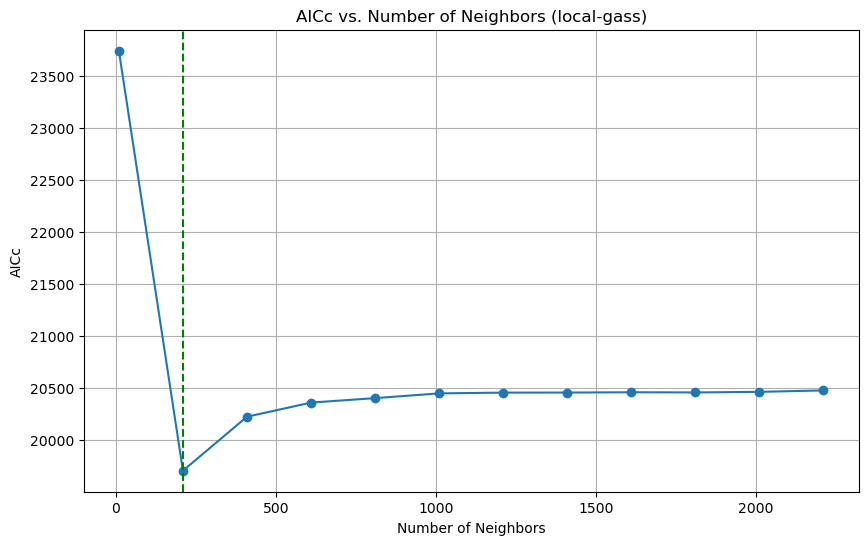

In [12]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors (local-gass)')
plt.grid(True)
plt.show()

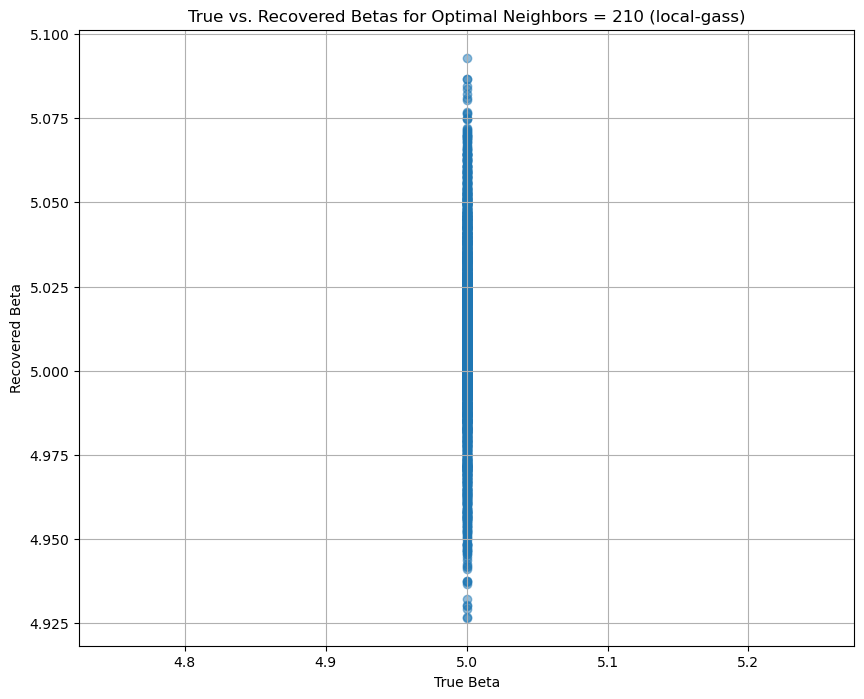

In [13]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
# val = 40
# single, aicc, enp = perform_local_regression(val, loc1, loc2, S2, y)

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} (local-gass)')
plt.grid(True) 
plt.show()

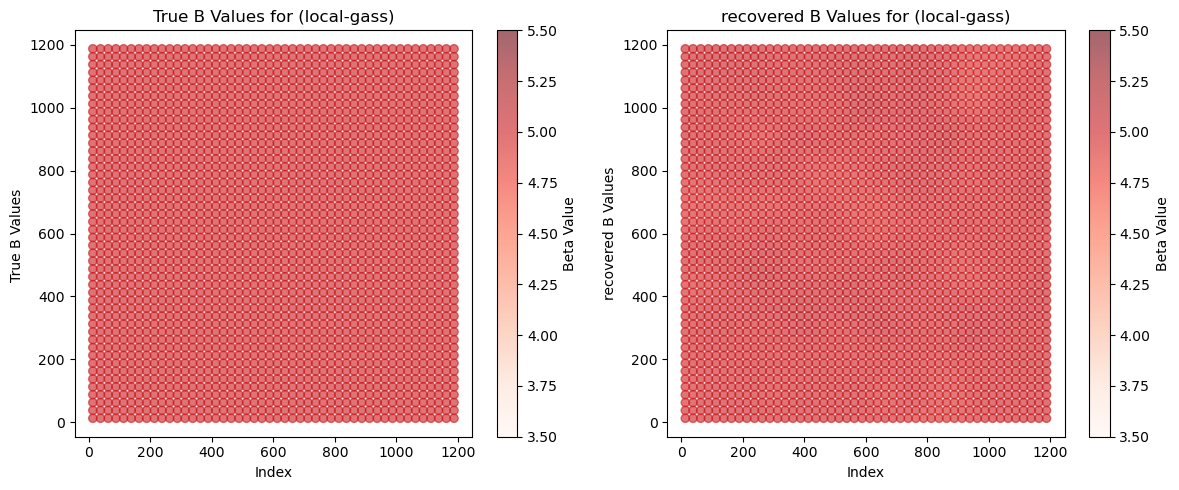

In [14]:
plot_true_and_recovered(B, recovered_betas_best, loc2, name='(local-gass)')

In [15]:
B

array([5, 5, 5, ..., 5, 5, 5])

In [16]:
recovered_betas_best.round(1)

array([5., 5., 5., ..., 5., 5., 5.])

In [17]:
B.min(), B.max()

(5, 5)

In [18]:
recovered_betas_best.min(), recovered_betas_best.max()

(4.926628162675533, 5.092958596251806)

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# --- Compute Model Metrics Function ---
def compute_model_metrics(y_true, y_pred, beta_true, beta_estimated, best_aicc, method_name):
    """
    Compute R², MSE, and AICc for a given model.
    """
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100 # Adding small epsilon to avoid division by zero
    
    # Compute MAE and R² for beta estimates
    mae_beta = np.mean(np.abs(beta_true - beta_estimated))  # MAE for beta
    r2_beta = r2_score(beta_true, beta_estimated)  # R² for beta

    return {
        "Method": method_name,
        "R²": round(r2, 3), 
        "MSE": round(mse, 3),
        "AICc": round(best_aicc, 3),
        "MAPE": round(mape, 3),
        "MAE_beta": round(mae_beta, 3)
    }

glass_metrics = compute_model_metrics(y_orig, y_pred_best, B, recovered_betas_best, best_aicc, 'GLASS')
pd.DataFrame([glass_metrics])

Method     R²      MSE       AICc   MAPE  MAE_beta
0  GLASS  0.317  297.874  19707.376  5.537     0.023

In [20]:
y_pred

array([251.702, 251.433, 251.58 , ..., 252.423, 252.761, 252.679])

In [21]:
y_orig

array([244.662, 245.063, 250.109, ..., 248.062, 242.998, 256.589])

In [22]:
B

array([5, 5, 5, ..., 5, 5, 5])

In [23]:
recovered_betas_best

array([4.987, 4.986, 4.983, ..., 4.996, 4.991, 4.984])

<br />
<br />
<br />

#### Aggregating points into census tracts for GWR

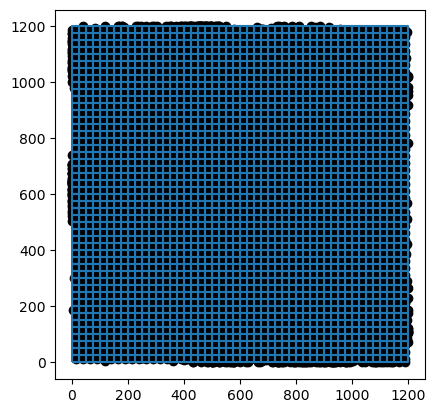

In [24]:
tracts_gdf48.boundary.plot()
plt.scatter(loc1[:,0], loc1[:,1], color='k')

In [25]:
df_S1 = gpd.GeoDataFrame({'S1': S1}, geometry=gpd.points_from_xy(loc1[:, 0], loc1[:, 1]))

In [26]:
df_S1.head()

S1                geometry
0  43.842736   POINT (12.500 12.500)
1  33.568500   POINT (12.500 37.500)
2   8.853738   POINT (12.500 62.500)
3  13.420882   POINT (12.500 87.500)
4  86.660393  POINT (12.500 112.500)

#### Spatial Join and mean-aggregation

In [27]:
joined = gpd.sjoin(df_S1, S2, how='left', predicate='within')

In [28]:
joined.head()

S1                geometry  index_right  tract_id
0  43.842736   POINT (12.500 12.500)          0.0       0.0
1  33.568500   POINT (12.500 37.500)          1.0       1.0
2   8.853738   POINT (12.500 62.500)          2.0       2.0
3  13.420882   POINT (12.500 87.500)          3.0       3.0
4  86.660393  POINT (12.500 112.500)          4.0       4.0

<Axes: >

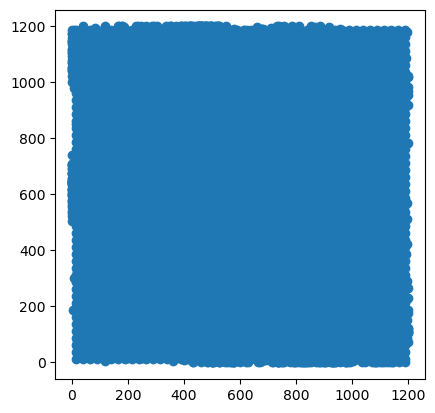

In [29]:
joined.plot()

In [30]:
sX = joined.groupby('tract_id').agg({'S1': ['mean']})#.reset_index()

In [31]:
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

In [32]:
# merge back with tracts (S1)
sX1 = S2.merge(sX, on='tract_id', how='left')

In [33]:
sX1.head()

tract_id                                           geometry    S1_mean
0         0  POLYGON ((0.000 0.000, 25.000 0.000, 25.000 25...  43.842736
1         1  POLYGON ((0.000 25.000, 25.000 25.000, 25.000 ...  33.568500
2         2  POLYGON ((0.000 50.000, 25.000 50.000, 25.000 ...  41.570741
3         3  POLYGON ((0.000 75.000, 25.000 75.000, 25.000 ...  13.420882
4         4  POLYGON ((0.000 100.000, 25.000 100.000, 25.00...  61.294669

In [34]:
sX1.isna().sum()

tract_id    0
geometry    0
S1_mean     0
dtype: int64

##### 523 missing values after spatial join. This speaks to one of the drawbacks of using this method

In [35]:
sX1.fillna({'S1_mean': 0}, inplace=True)

In [36]:
gwr_X  = sX1['S1_mean'].values.reshape(-1,1)
gwr_y = y_orig.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])

In [37]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

std_X = scaler_x.fit_transform(gwr_X.reshape(-1,1))
std_y = scaler_y.fit_transform(gwr_y.reshape(-1,1))

In [38]:
gwr_y.std()

20.88713487728043

In [39]:
gwr_X.std()

23.74960008377353

In [40]:
gwr_X.shape, gwr_y.shape

((2304, 1), (2304, 1))

##### Calibrate GWR

In [41]:
len(smoothed_S1_to_S2)

2304

In [42]:
gwr_y.shape

(2304, 1)

In [43]:
smoothed_S1_to_S2.reshape(-1, 1)

array([[48.932],
       [49.013],
       [50.022],
       ...,
       [49.612],
       [48.6  ],
       [51.318]])

In [44]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw = gwr_selector.search()
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw, constant=False).fit()
print(gwr_bw)

1488.0


In [45]:
params = gwr_results.params
y_pred_gwr = gwr_results.predy
aicc_gwr_m = gwr_results.aicc

print(gwr_results.aicc), print(gwr_results.R2);

28035.094068198974
-24.72948247462089


In [46]:
y_pred_gwr

array([[178.017],
       [136.322],
       [168.883],
       ...,
       [295.729],
       [338.428],
       [229.963]])

In [47]:
y_orig

array([244.662, 245.063, 250.109, ..., 248.062, 242.998, 256.589])

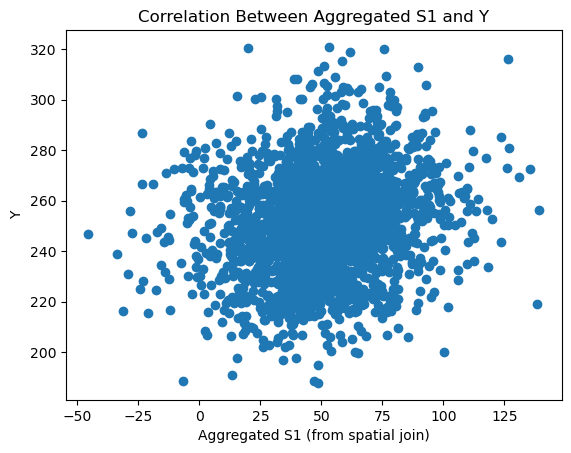

In [48]:
plt.scatter(sX1['S1_mean'], gwr_y)
plt.xlabel("Aggregated S1 (from spatial join)")
plt.ylabel("Y")
plt.title("Correlation Between Aggregated S1 and Y")
plt.show()

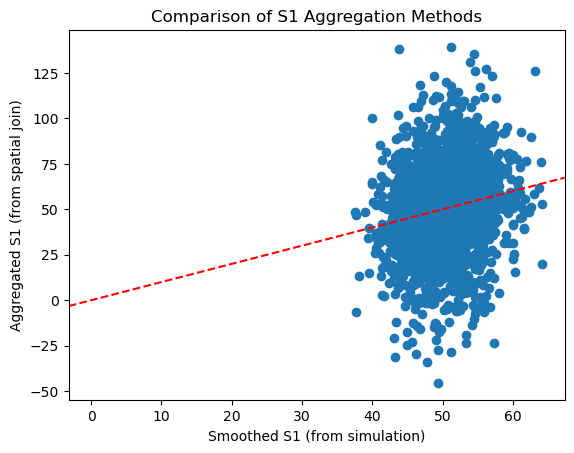

In [49]:
plt.scatter(smoothed_S1_to_S2, sX1['S1_mean'])
plt.xlabel("Smoothed S1 (from simulation)")
plt.ylabel("Aggregated S1 (from spatial join)")
plt.title("Comparison of S1 Aggregation Methods")
plt.axline((0, 0), slope=1, color='r', linestyle='--')  # 1:1 reference line
plt.show()


In [50]:
print("Variance of y:", np.var(gwr_y))
print("Variance of residuals:", np.var(gwr_results.resid_response))


Variance of y: 436.27240338170463
Variance of residuals: 9221.740064684815


In [51]:
params.shape

(2304, 1)

In [52]:
params.min(), params.max()

(4.0260589021205435, 4.249900670745798)

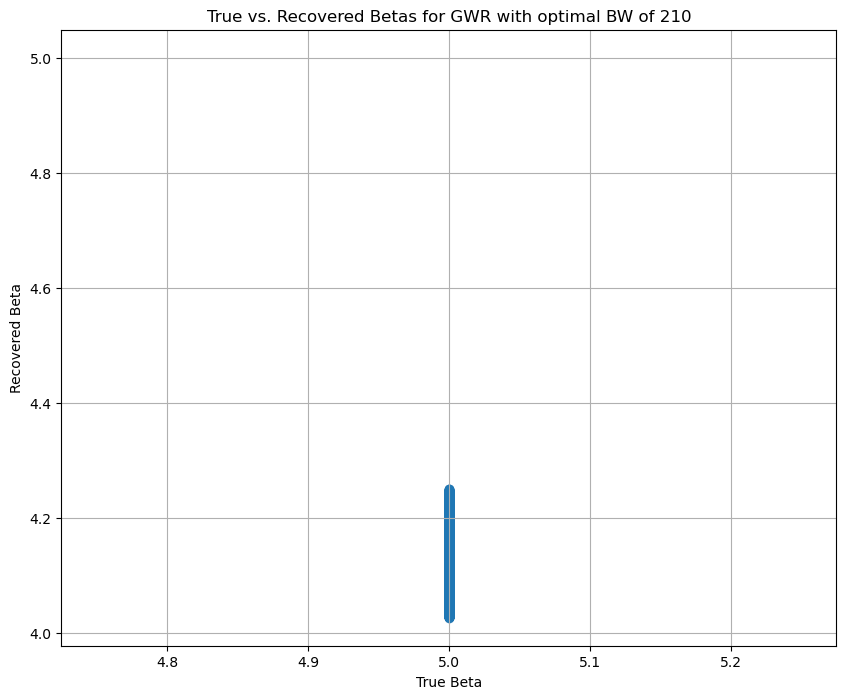

In [53]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params.ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}")
plt.grid(True)
plt.show()

In [54]:
# R2

In [55]:
# std_B = scaler.fit_transform(B.reshape(-1,1))

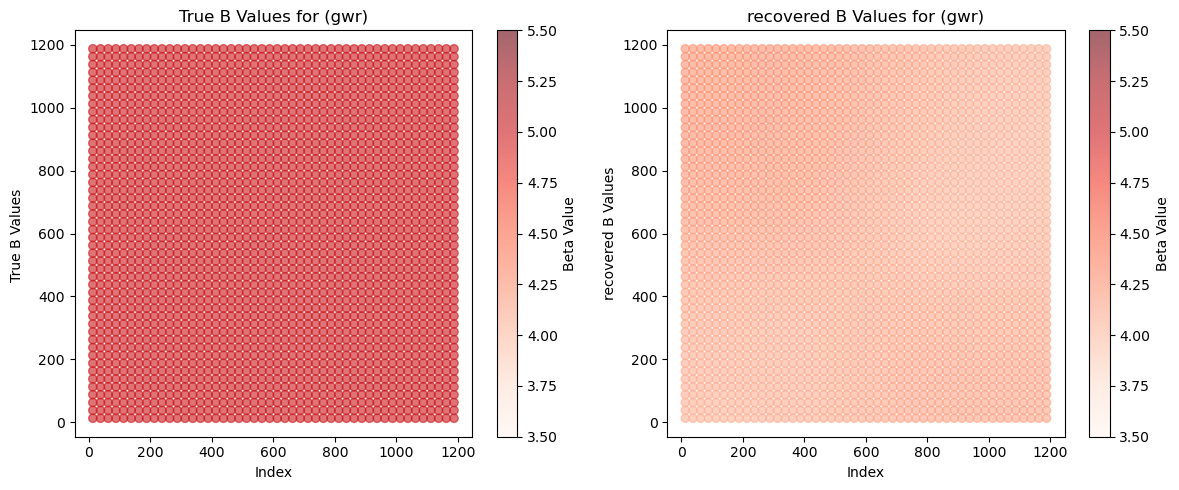

In [56]:
plot_true_and_recovered(B, params, loc2, name='(gwr)')

In [57]:
B

array([5, 5, 5, ..., 5, 5, 5])

In [58]:
params.round(1).flatten()

array([4.1, 4.1, 4.1, ..., 4. , 4.1, 4.1])

In [59]:
B.min(), B.max()

(5, 5)

In [60]:
params.min(), params.max()

(4.0260589021205435, 4.249900670745798)

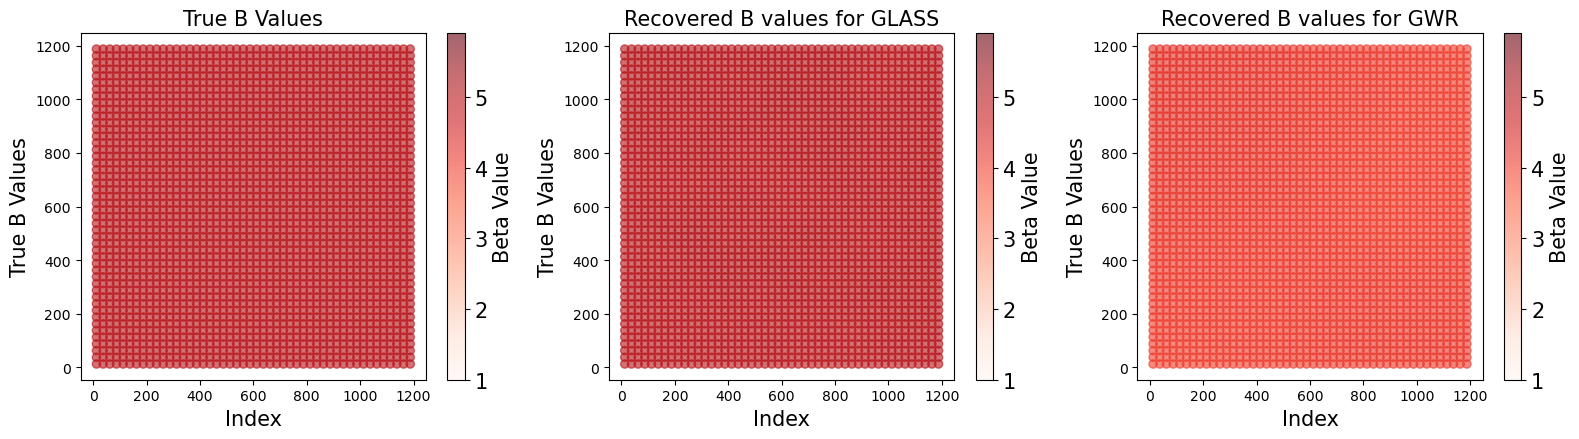

In [61]:
def plot_true_gass_gwr(true, local_gass, gwr,  coord):
    plt.figure(figsize=(16, 4.5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', vmin=1, vmax=5.9, alpha=0.6)
    plt.xlabel('Index', size=15)
    plt.ylabel('True B Values', size=15)
    cbar= plt.colorbar(label='Beta Value')
    cbar.set_label('Beta Value', fontsize=15)  # Set label with font size
    cbar.ax.tick_params(labelsize=15)  # Set tick label font size
    plt.title(f'True B Values', size=15)
    
    plt.subplot(1, 3, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=local_gass, cmap='Reds', vmin=1, vmax=5.9, alpha=0.6)
    plt.xlabel('Index', size=15)
    plt.ylabel('True B Values', size=15)
    cbar= plt.colorbar(label='Beta Value')
    cbar.set_label('Beta Value', fontsize=15)  # Set label with font size
    cbar.ax.tick_params(labelsize=15)  # Set tick label font size
    plt.title(f'Recovered B values for GLASS', size=15)

    plt.subplot(1, 3, 3)
    plt.scatter(coord[:,0], coord[:, 1], c=gwr, cmap='Reds', vmin=1, vmax=5.9, alpha=0.6)
    plt.xlabel('Index', size=15)
    plt.ylabel('True B Values', size=15)
    cbar= plt.colorbar(label='Beta Value')
    cbar.set_label('Beta Value', fontsize=15)  # Set label with font size
    cbar.ax.tick_params(labelsize=15)  # Set tick label font size
    plt.title(f'Recovered B values for GWR', size=15)
    
    plt.tight_layout()
    plt.show()

plot_true_gass_gwr(B, recovered_betas_best, params, loc2)

In [62]:
gwr_metrics = compute_model_metrics(y_orig, y_pred_gwr, B, params, gwr_results.aicc, 'GWR')
pd.DataFrame([gwr_metrics])

Method      R²        MSE       AICc    MAPE  MAE_beta
0    GWR -24.729  11225.063  28035.094  33.828     0.884

##### They both recover the true scale but GWR has more errors in recovering the true betas..

<br />

### Next experiment will be increasing the size of the tracts to 24x24 grids (576 tracts) and have the results compared

##### Here, i have increased the dimension to 24 x 24. It was previously 48 x 48. 

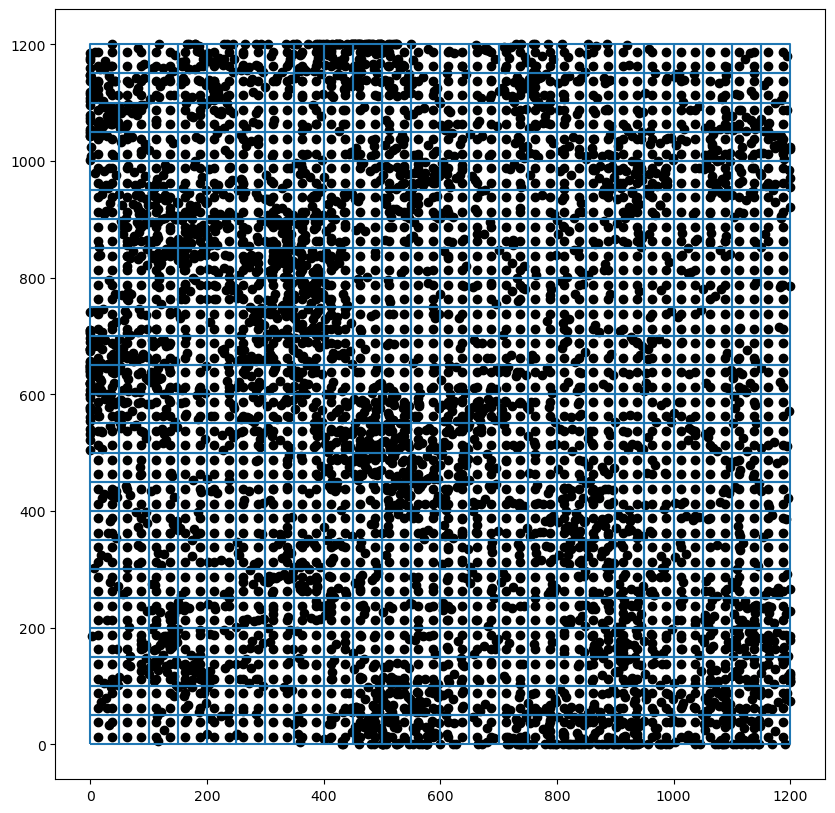

In [63]:
x_step, y_step = 50, 50  # Creates a 20x20 grid, resulting in 225 tracts cell divisions
tracts_gdf24 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)


y_24 = tracts_gdf48.copy()
y_24['y'] = y_orig

spj24 = gpd.sjoin(y_24, tracts_gdf24, how='left', predicate='within')
y_spj24 = spj24.groupby('tract_id_right')['y'].mean().values


S2 = tracts_gdf24
loc2 = np.array([[point.x, point.y] for point in S2.geometry.centroid])


B = uniform(loc2)

# B = uniform(loc1)
tracts_gdf24.boundary.plot(figsize=(10, 10))
plt.scatter(loc1[:,0], loc1[:,1], color='k')

In [64]:
len(tracts_gdf24), len(S1), len(S2), len(loc1), len(loc2)

(576, 5504, 576, 5504, 576)

In [65]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S2), 50))
best_aicc = float('inf')
y_pred_best = None
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, y_pred, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S1, S2, y_spj24)
    aicc_values.append(aicc)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas
        y_pred_best = y_pred # store best predictions

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 52
Best AICc: 3742.37


In [66]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

52

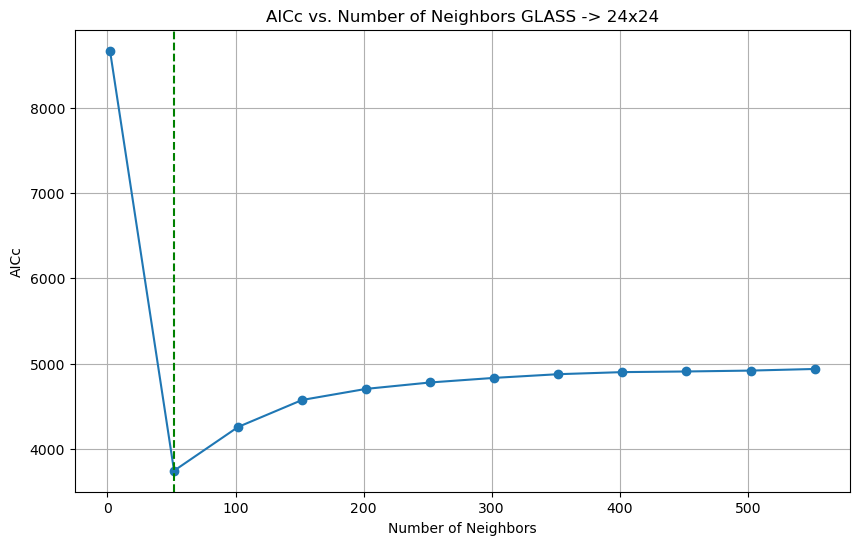

In [67]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors GLASS -> 24x24')
plt.grid(True)
plt.show()

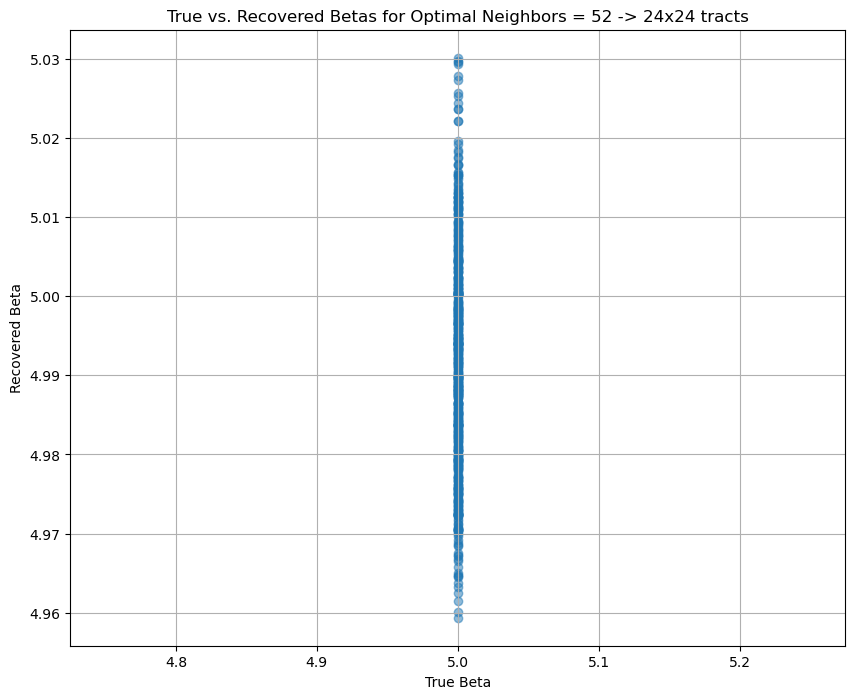

In [68]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} -> 24x24 tracts')
plt.grid(True)
plt.show()

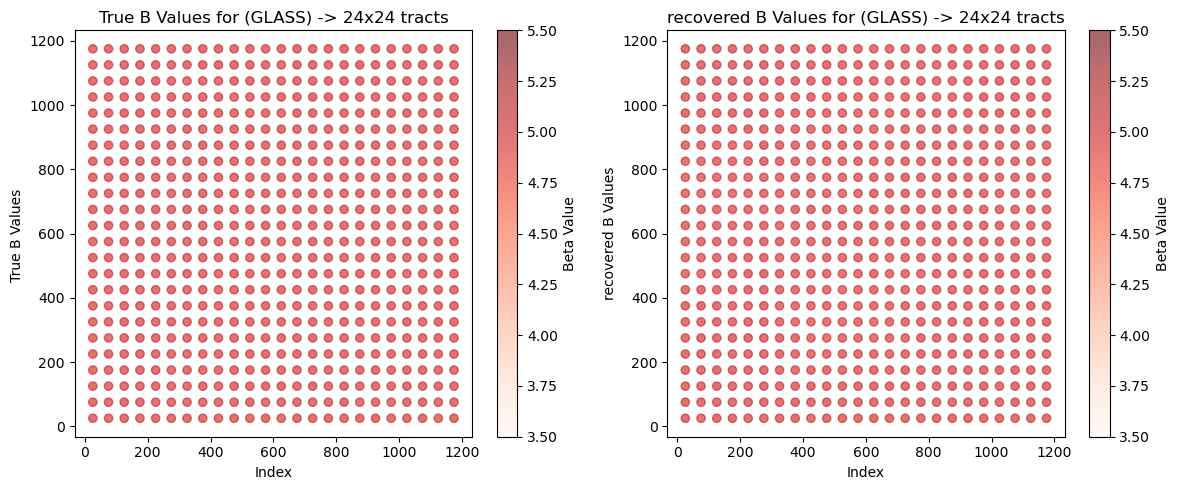

In [69]:
plot_true_and_recovered(B, recovered_betas_best, loc2, name='(GLASS) -> 24x24 tracts')

In [70]:
B.min(), B.max()

(5, 5)

In [71]:
recovered_betas_best.min(), recovered_betas_best.max()

(4.959356270688512, 5.030141362370561)

In [72]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

glass_metrics = compute_model_metrics(y_spj24, y_pred_best, B, recovered_betas_best, best_aicc, 'GLASS')
pd.DataFrame([glass_metrics])

Method     R²     MSE     AICc   MAPE  MAE_beta
0  GLASS  0.896  35.936  3742.37  1.877     0.013

<br />

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [73]:
df_S1 = gpd.GeoDataFrame({'S1': S1}, geometry=gpd.points_from_xy(loc1[:, 0], loc1[:, 1]))
joined = gpd.sjoin(df_S1, S2, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S1': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S2.merge(sX, on='tract_id', how='left')
sX1.fillna({'S1_mean': 0}, inplace=True)

In [74]:
sX1.head()

tract_id                                           geometry    S1_mean
0         0  POLYGON ((0.000 0.000, 50.000 0.000, 50.000 50...  53.950723
1         1  POLYGON ((0.000 50.000, 50.000 50.000, 50.000 ...  43.840035
2         2  POLYGON ((0.000 100.000, 50.000 100.000, 50.00...  55.713150
3         3  POLYGON ((0.000 150.000, 50.000 150.000, 50.00...  60.119000
4         4  POLYGON ((0.000 200.000, 50.000 200.000, 50.00...  57.955797

##### Specify GWR parameters

In [75]:
gwr_X  = sX1['S1_mean'].values.reshape(-1,1)
gwr_y = y_spj24.reshape(-1, 1) # using aggregated y
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((576, 1), (576, 1))

In [76]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw = gwr_selector.search()
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw, constant=False).fit()
print(gwr_bw)

575.0


In [77]:
params = gwr_results.params
y_pred_gwr = gwr_results.predy
aicc_gwr_m = gwr_results.aicc

print(gwr_results.aicc), print(gwr_results.R2);

6146.040342232472
-6.243279868454742


In [78]:
params.min(), params.max()

(4.7832400379186115, 4.801810420941097)

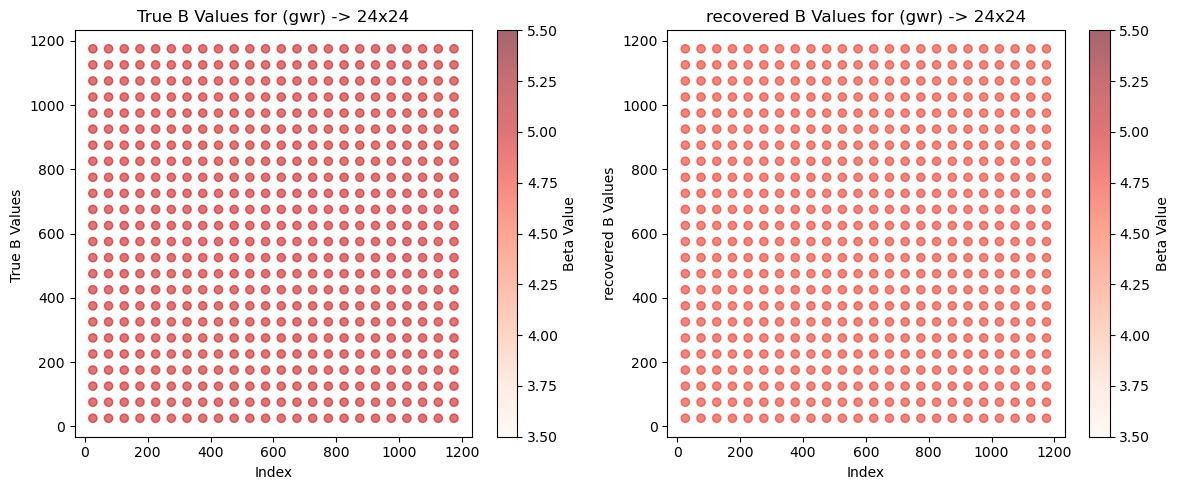

In [79]:
plot_true_and_recovered(B, params, loc2, name='(gwr) -> 24x24')

In [80]:
B.min(), B.max()

(5, 5)

In [81]:
params.min(), params.max()

(4.7832400379186115, 4.801810420941097)

<b />

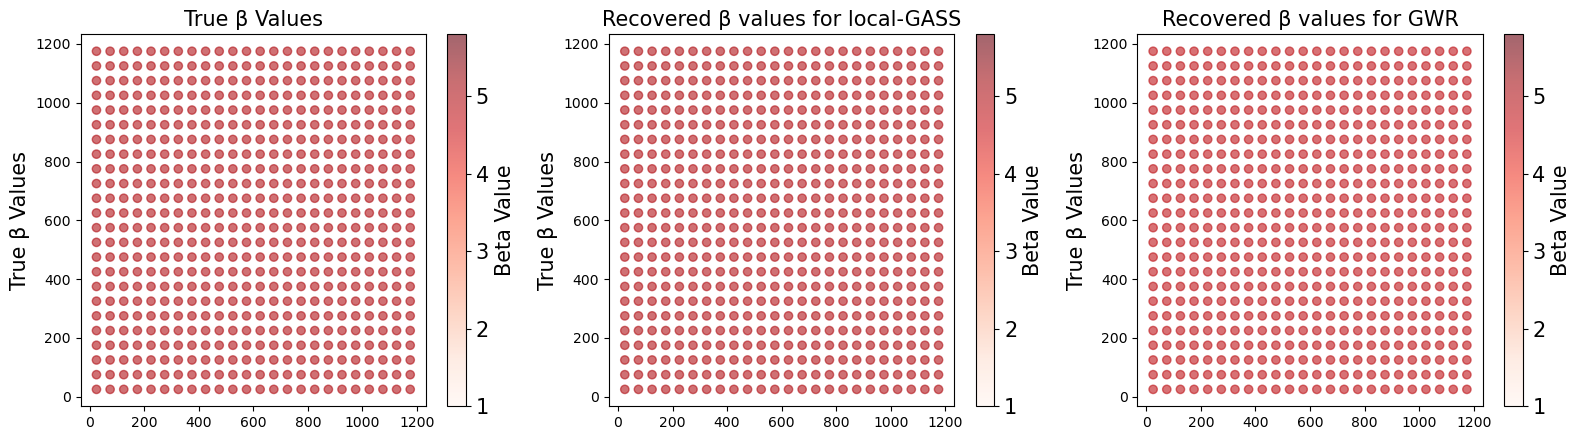

In [82]:
def plot_true_gass_gwr(true, local_gass, gwr,  coord):
    plt.figure(figsize=(16, 4.5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', vmin=1, vmax=5.8, alpha=0.6)
    # plt.xlabel('Index', size=15)
    plt.ylabel('True β Values', size=15)
    cbar= plt.colorbar(label='Beta Value')
    cbar.set_label('Beta Value', fontsize=15)  # Set label with font size
    cbar.ax.tick_params(labelsize=15)  # Set tick label font size
    plt.title(f'True β Values', size=15)
    
    plt.subplot(1, 3, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=local_gass, cmap='Reds', vmin=1, vmax=5.8, alpha=0.6)
    # plt.xlabel('Index', size=15)
    plt.ylabel('True β Values', size=15)
    cbar= plt.colorbar(label='Beta Value')
    cbar.set_label('Beta Value', fontsize=15)  # Set label with font size
    cbar.ax.tick_params(labelsize=15)  # Set tick label font size
    plt.title(f'Recovered β values for local-GASS', size=15)

    plt.subplot(1, 3, 3)
    plt.scatter(coord[:,0], coord[:, 1], c=gwr, cmap='Reds', vmin=1, vmax=5.8, alpha=0.6)
    # plt.xlabel('Index', size=15)
    plt.ylabel('True β Values', size=15)
    cbar= plt.colorbar(label='Beta Value')
    cbar.set_label('Beta Value', fontsize=15)  # Set label with font size
    cbar.ax.tick_params(labelsize=15)  # Set tick label font size
    plt.title(f'Recovered β values for GWR', size=15)
    
    plt.tight_layout()
    plt.show()

plot_true_gass_gwr(B, recovered_betas_best, params, loc2)

In [83]:
gwr_metrics = compute_model_metrics(y_spj24, y_pred_gwr, B, params, gwr_results.aicc, 'GWR')
pd.DataFrame([gwr_metrics])

Method     R²       MSE     AICc    MAPE  MAE_beta
0    GWR -6.243  2495.407  6146.04  18.015     0.206

### Further increasing the size of the tracts to 16x16 grids (256 tracts) and have the results compared

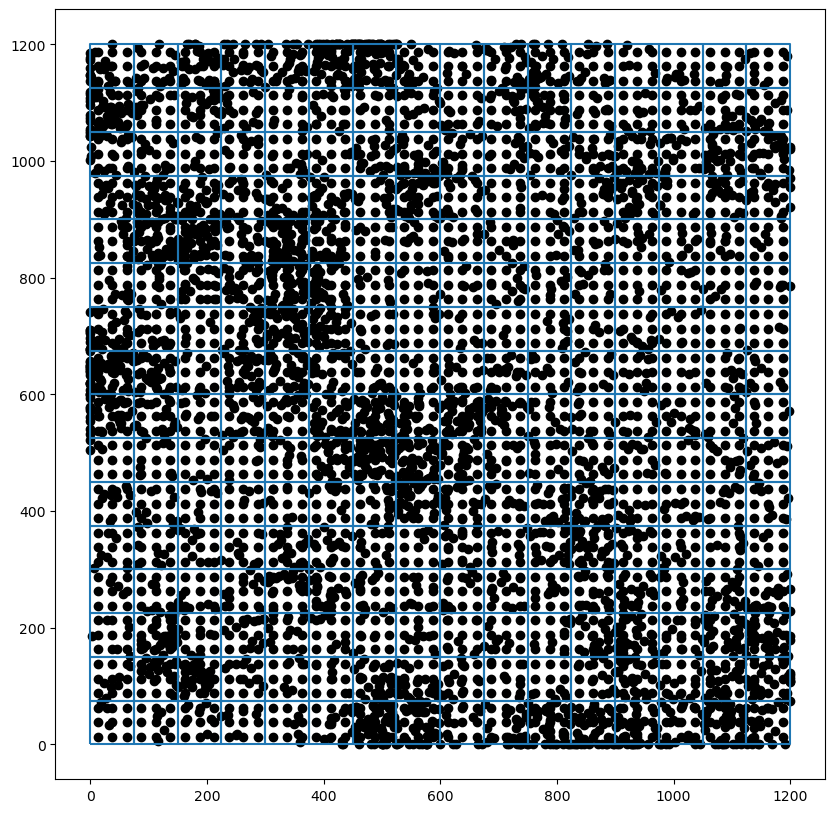

In [84]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 75, 75  # Creates a 16x16 grid, resulting in 256 tracts cell divisions
tracts_gdf16 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

y_16 = tracts_gdf48.copy()  # make all of these a function. too much repetition
y_16['y'] = y_orig

spj16 = gpd.sjoin(y_16, tracts_gdf16, how='left', predicate='within')
y_spj16 = spj16.groupby('tract_id_right')['y'].mean().values # aggregate y values to 16x16 tracts

S2 = tracts_gdf16
loc2 = np.array([[point.x, point.y] for point in tracts_gdf16.geometry.centroid])

B = uniform(loc2)

tracts_gdf16.boundary.plot(figsize=(10, 10))
plt.scatter(loc1[:,0], loc1[:,1], color='k')

In [85]:
len(S1), len(y_spj16), len(loc2), len(loc1)

(5504, 256, 256, 5504)

In [86]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S2), 30))
best_aicc = float('inf')
y_pred_best = None
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, y_pred, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S1, S2, y_spj16)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas
        y_pred_best = y_pred # store best predictions

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 62
Best AICc: 1696.39


In [87]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

62

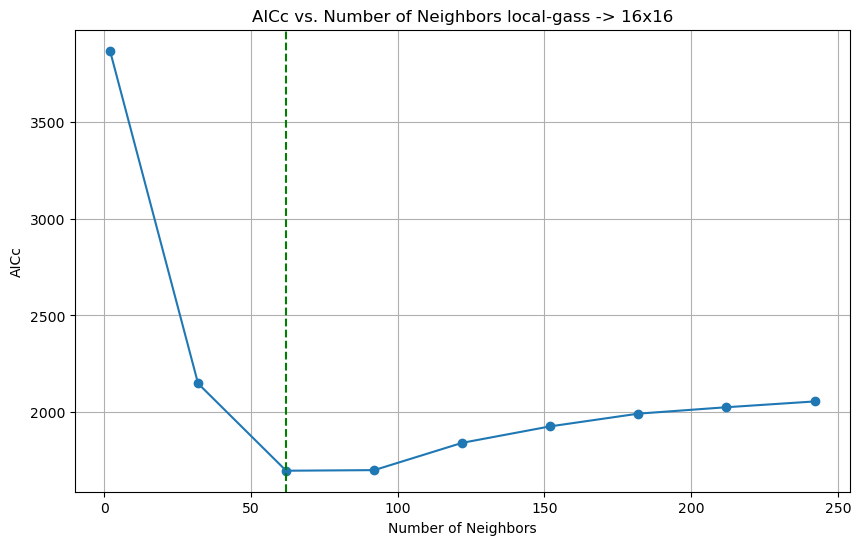

In [88]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 16x16')
plt.grid(True)
plt.show()

In [89]:
len(B)

256

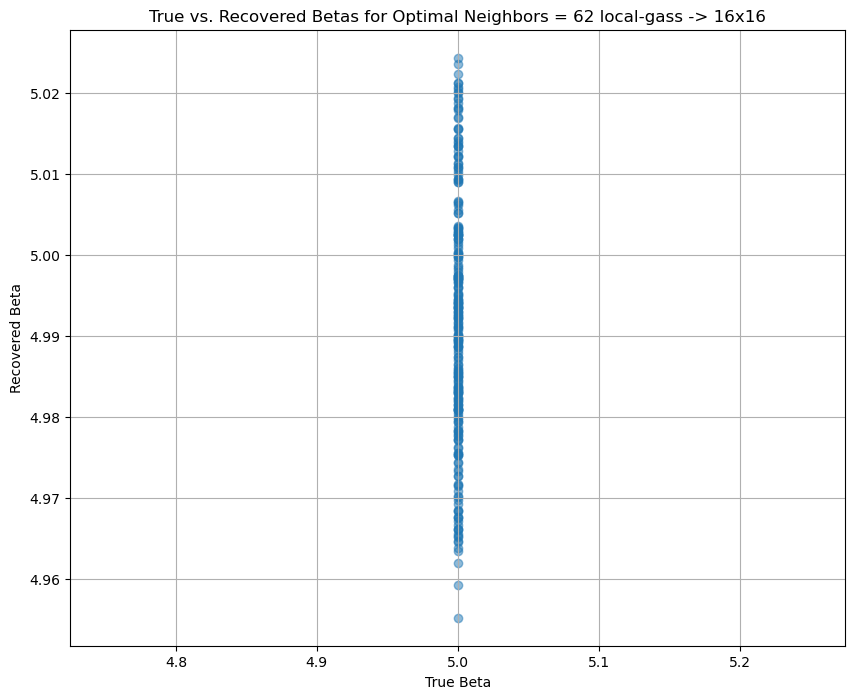

In [90]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 16x16')
plt.grid(True)
plt.show()

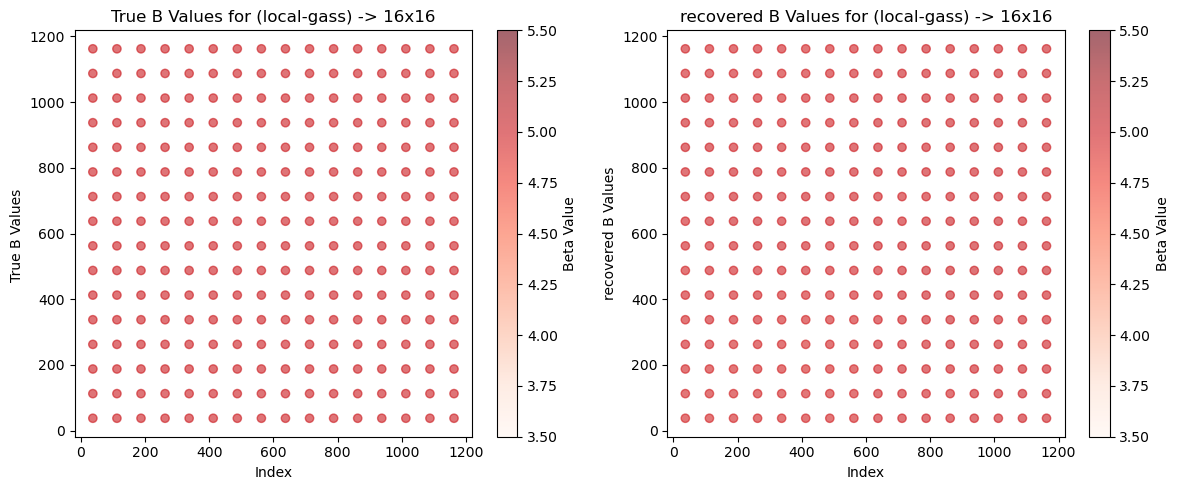

In [91]:
plot_true_and_recovered(B, recovered_betas_best, loc2, name='(local-gass) -> 16x16')

In [92]:
B.min(), B.max()

(5, 5)

In [93]:
recovered_betas_best.min(), recovered_betas_best.max()

(4.955177098681709, 5.024295716445146)

In [94]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

glass_metrics = compute_model_metrics(y_spj16, y_pred_best, B, recovered_betas_best, best_aicc, 'GLASS')
pd.DataFrame([glass_metrics])

Method     R²     MSE      AICc   MAPE  MAE_beta
0  GLASS  0.857  41.223  1696.387  2.077     0.014

<br />

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [95]:
df_S1 = gpd.GeoDataFrame({'S1': S1}, geometry=gpd.points_from_xy(loc1[:, 0], loc1[:, 1]))
joined = gpd.sjoin(df_S1, S2, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S1': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S2)
sX1 = S2.merge(sX, on='tract_id', how='left')
sX1.fillna({'S1_mean': 0}, inplace=True)

In [96]:
sX1.head()

tract_id                                           geometry    S1_mean
0         0  POLYGON ((0.000 0.000, 75.000 0.000, 75.000 75...  46.362963
1         1  POLYGON ((0.000 75.000, 75.000 75.000, 75.000 ...  54.548654
2         2  POLYGON ((0.000 150.000, 75.000 150.000, 75.00...  56.861233
3         3  POLYGON ((0.000 225.000, 75.000 225.000, 75.00...  47.050822
4         4  POLYGON ((0.000 300.000, 75.000 300.000, 75.00...  42.111083

##### Specify GWR parameters

In [97]:
gwr_X  = sX1['S1_mean'].values.reshape(-1,1)
gwr_y = y_spj16.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((256, 1), (256, 1))

In [98]:
gwr_selector = Sel_BW(coords, gwr_y, gwr_X, constant=False)
gwr_bw = gwr_selector.search()
gwr_results = GWR(coords, gwr_y, gwr_X, gwr_bw, constant=False).fit()
print(gwr_bw)

255.0


In [99]:
params = gwr_results.params
y_pred_gwr = gwr_results.predy
aicc_gwr_m = gwr_results.aicc

print(gwr_results.aicc), print(gwr_results.R2);

2454.094831309933
-1.8805879948299529


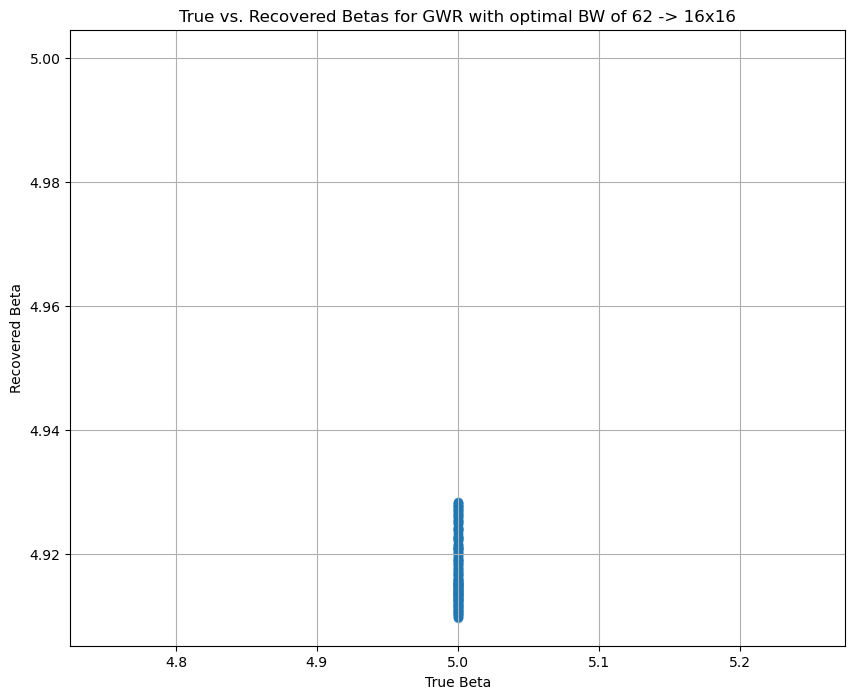

In [100]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params.ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 16x16")
plt.grid(True)
plt.show()

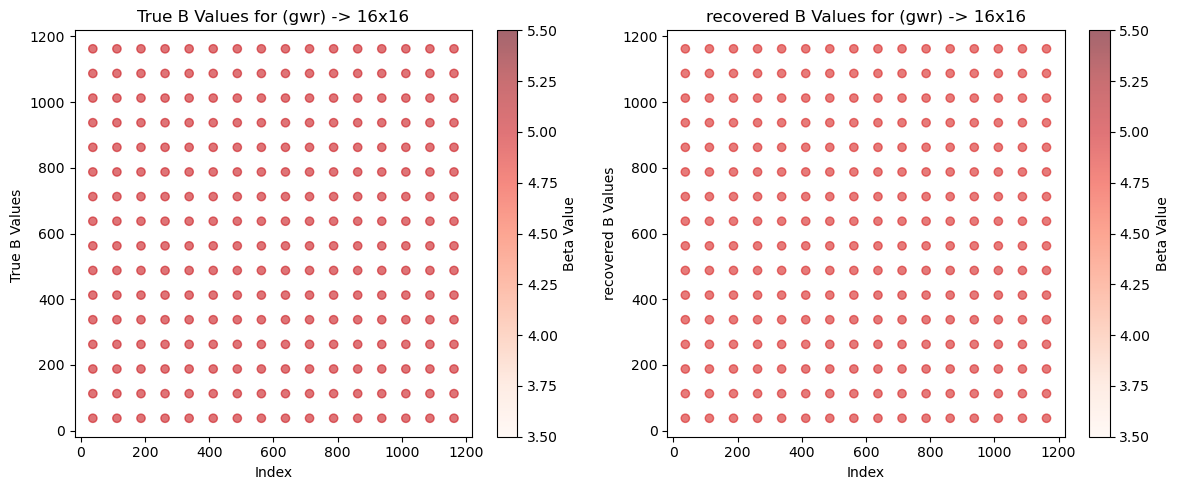

In [101]:
plot_true_and_recovered(B, params, loc2, name='(gwr) -> 16x16')

In [102]:
B.min(), B.max()

(5, 5)

In [103]:
params.min(), params.max()

(4.909741214870657, 4.928333201834305)

<br >

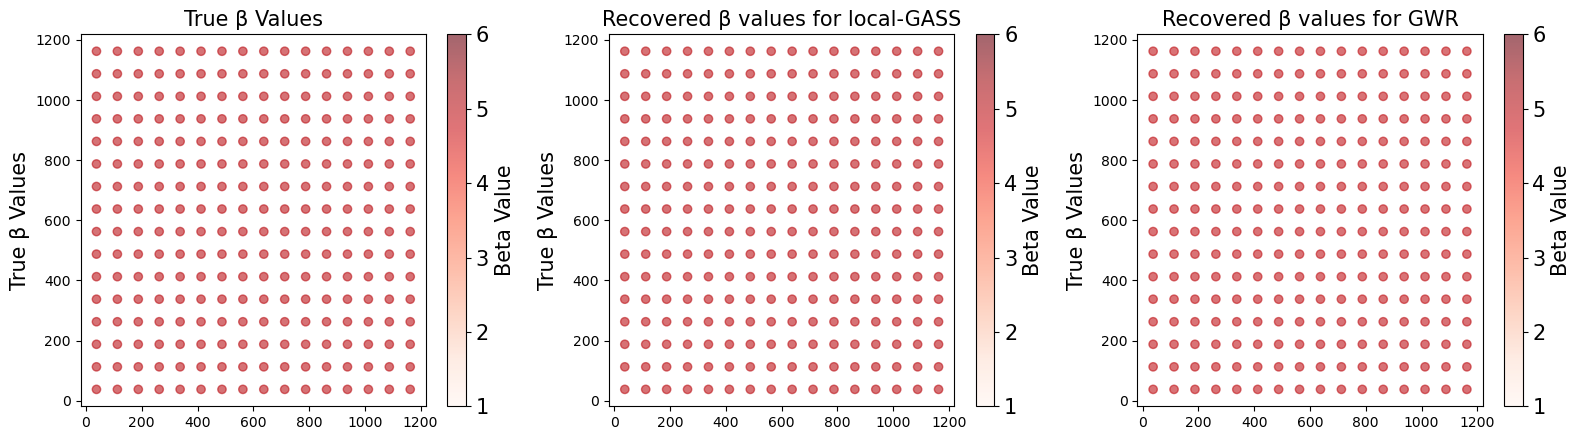

In [104]:
def plot_true_gass_gwr(true, local_gass, gwr,  coord):
    plt.figure(figsize=(16, 4.5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', vmin=1, vmax=6, alpha=0.6)
    # plt.xlabel('Index', size=15)
    plt.ylabel('True β Values', size=15)
    cbar= plt.colorbar(label='Beta Value')
    cbar.set_label('Beta Value', fontsize=15)  # Set label with font size
    cbar.ax.tick_params(labelsize=15)  # Set tick label font size
    plt.title(f'True β Values', size=15)
    
    plt.subplot(1, 3, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=local_gass, cmap='Reds', vmin=1, vmax=6, alpha=0.6)
    # plt.xlabel('Index', size=15)
    plt.ylabel('True β Values', size=15)
    cbar= plt.colorbar(label='Beta Value')
    cbar.set_label('Beta Value', fontsize=15)  # Set label with font size
    cbar.ax.tick_params(labelsize=15)  # Set tick label font size
    plt.title(f'Recovered β values for local-GASS', size=15)

    plt.subplot(1, 3, 3)
    plt.scatter(coord[:,0], coord[:, 1], c=gwr, cmap='Reds', vmin=1, vmax=6, alpha=0.6)
    # plt.xlabel('Index', size=15)
    plt.ylabel('True β Values', size=15)
    cbar= plt.colorbar(label='Beta Value')
    cbar.set_label('Beta Value', fontsize=15)  # Set label with font size
    cbar.ax.tick_params(labelsize=15)  # Set tick label font size
    plt.title(f'Recovered β values for GWR', size=15)
    
    plt.tight_layout()
    plt.show()

plot_true_gass_gwr(B, recovered_betas_best, params, loc2)

In [105]:
gwr_metrics = compute_model_metrics(y_spj16, y_pred_gwr, B, params, gwr_results.aicc, 'GWR')
pd.DataFrame([gwr_metrics])

Method     R²      MSE      AICc   MAPE  MAE_beta
0    GWR -1.881  832.924  2454.095  13.02     0.082

### Further increasing the size of the tracts to 8x8 grids (64 tracts) and have the results compared

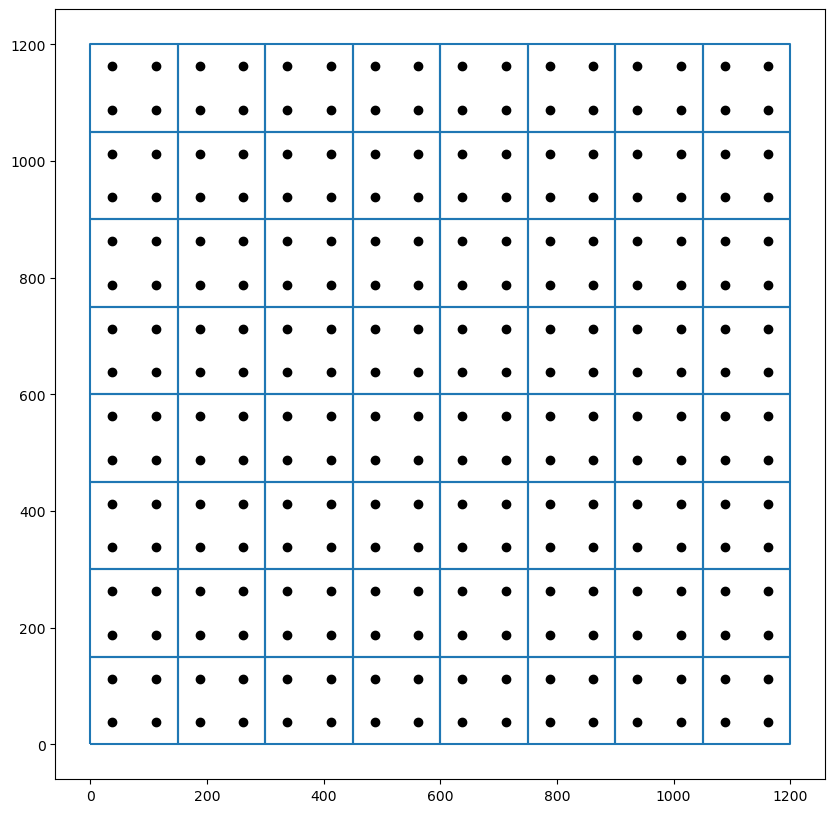

In [114]:
x_step, y_step = 150, 150  # Creates a 8x8 grid, resulting in 64 tracts
tracts_gdf8 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2
y_8 = tracts_gdf48.copy()  # make all of these a function. too much repetition
y_8['y'] = y_orig

spj8 = gpd.sjoin(y_8, tracts_gdf8, how='left', predicate='within')
y_spj8 = spj8.groupby('tract_id_right')['y'].mean().values

S1 = tracts_gdf8
S2 = S2
loc1 = np.array([[point.x, point.y] for point in tracts_gdf8.geometry.centroid])
loc2 = loc2

B = create_beta_surface(loc1, heterogeneity='low')

tracts_gdf8.boundary.plot(figsize=(10, 10))
plt.scatter(loc2[:,0], loc2[:,1], color='k');

In [115]:
len(S1), len(y_spj8), len(S2)

(64, 64, 256)

In [116]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 4))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y_spj8)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

TypeError: perform_local_regression() missing 1 required positional argument: 'y'

In [ ]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

In [ ]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 8x8')
plt.grid(True)
plt.show()

In [ ]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 8x8')
plt.grid(True)
plt.show()

In [ ]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 8x8')

In [ ]:
B

In [ ]:
recovered_betas_best.round(1)

In [ ]:
B.min(), B.max()

In [ ]:
recovered_betas_best.min(), recovered_betas_best.max()

<br />

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [ ]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0}, inplace=True)

In [ ]:
sX1.head()

##### Specify GWR parameters

In [ ]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y_spj8.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

In [ ]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(2, len(loc1), 4))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [ ]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [ ]:
min(dict_aicc, key=dict_aicc.get)

In [ ]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 8x8')
plt.grid(True)
plt.show()

In [ ]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}  -> 8x8")
plt.grid(True)
plt.show()

In [ ]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) --> 8x8')

In [ ]:
B.min(), B.max()

In [ ]:
params[0].min(), params[0].max()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Create 2x2 grid of subplots

# 48x48 grid
x_step5, y_step5 = 25, 25  # 48x48 grid
tracts_gdf5 = create_tracts(xmin, xmax, ymin, ymax, x_step5, y_step5)
S25, loc25 = simulate_clustered_S2(num_points=1500, background_points=1200, num_clusters=15, 
                                   cluster_std=30, random_state=12)
tracts_gdf5.boundary.plot(ax=axs[0, 0])  # Plot on top-left
axs[0, 0].scatter(loc25[:, 0], loc25[:, 1], color='k')
axs[0, 0].set_title('2307 cells aggregation (48x48)')

# 24x24 grid
x_step7, y_step7 = 50, 50  # 24x24 grid
tracts_gdf7 = create_tracts(xmin, xmax, ymin, ymax, x_step7, y_step7)
S27, loc27 = simulate_clustered_S2(num_points=1500, background_points=1200, num_clusters=15, 
                                   cluster_std=30, random_state=12)
tracts_gdf7.boundary.plot(ax=axs[0, 1])  # Plot on top-right
axs[0, 1].scatter(loc27[:, 0], loc27[:, 1], color='k')
axs[0, 1].set_title('576 cells aggregation (24x24)')

# 16x16 grid
x_step9, y_step9 = 75, 75  # 16x16 grid
tracts_gdf9 = create_tracts(xmin, xmax, ymin, ymax, x_step9, y_step9)
S29, loc29 = simulate_clustered_S2(num_points=1500, background_points=1200, num_clusters=15, 
                                   cluster_std=30, random_state=12)
tracts_gdf9.boundary.plot(ax=axs[1, 0])  # Plot on bottom-left
axs[1, 0].scatter(loc29[:, 0], loc29[:, 1], color='k')
axs[1, 0].set_title('256 cells aggregation (16x16)')

# 8x8 grid
x_step12, y_step12 = 150, 150  # 8x8 grid
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step12, y_step12)
S212, loc212 = simulate_clustered_S2(num_points=1500, background_points=1200, num_clusters=15, 
                                   cluster_std=30, random_state=12)
tracts_gdf12.boundary.plot(ax=axs[1, 1])  # Plot on bottom-right
axs[1, 1].scatter(loc212[:, 0], loc212[:, 1], color='k')
axs[1, 1].set_title('64 cells aggregation (8x8)')

# Adjust layout
plt.tight_layout()
plt.show()
